# San Francisco Crime Project

* Author: Kevin Chuang [@k-chuang](https://www.github.com/k-chuang)
* Created on: August 25, 2018
* Description: Data analysis, exploration, visualization, and data mining on crime in SF
* Original dataset: [SF Gov Crime dataset](https://data.sfgov.org/Public-Safety/-Change-Notice-Police-Department-Incidents/tmnf-yvry/about)
* Kaggle dataset: [Kaggle SF Crime](https://www.kaggle.com/c/sf-crime/data)

---------------

# Table of Contents

- Introduction
    - SF Crime Dataset
- Basic Preparation
    - Import libraries
    - Load data
- Data Exploration/Analysis Extension
- Data Preprocessing
    - Data Imputation/Removal
    - Feature Engineering
    - Feature Encoding
- Build Machine Learning Models
    - Train different baseline models
    - Analyze results
- Model Selection
- Hyperparameter tuning
- Train Model with optimal hyperparameters
- Feature Selection
    - Feature Importance
    - Feature Removal
- Train Final Model
- Model Evaluation
- Summary
- Kaggle Submission
- Conclusion

# Introduction


## SF Crime Dataset

This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015. The training set and test set rotate every week, meaning week 1,3,5,7... belong to test set, week 2,4,6,8 belong to training set. The goal is to try to predict the category of crime that occurred in the city of San Francisco. 

### Data Fields
- **Dates** - timestamp of the crime incident
- **Category** - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
- **Descript** - detailed description of the crime incident (only in train.csv)
- **DayOfWeek** - the day of the week
- **PdDistrict** - name of the Police Department District
- **Resolution** - how the crime incident was resolved (only in train.csv)
- **Address** - the approximate street address of the crime incident 
- **X** - Longitude
- **Y** - Latitude


In this juypter notebook, I will go through the whole process, end-to-end, of creating a machine learning model on the open source San Francisco Crime dataset. This includes data exploration & analysis, data preprocessing (huge part of this project and includes feature engineering), trying out different ML algorithms and determining the optimal ML model, tuning the hyperparameters of that model, and finally, evaluating the chosen model in terms of multiclass log loss. 

Since this is an old Kaggle competition, I will refrain from looking online for resources or old Kaggle kernels. The plan is to get better at coding an end to end data science project and to familiarize myself with the Python data science libraries. Also, I hope to learn some interesting things and discover some cool patterns or ideas using this dataset. Well, here goes nothing!



## Import libraries

In [1]:
__author__ = 'Kevin Chuang (https://www.github.com/k-chuang)' 

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

# Metrics 
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

# Model Selection & Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space  import Real, Categorical, Integer


# Clustering
from sklearn.cluster import KMeans

# Mathematical Functions
import math

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


# Data Exploration & Analysis Extension

- Complete data exploration & visualizations are located in jupyter notebook: [kaggle-sf-crime-data-exploration.ipynb](kaggle-sf-crime-data-exploration.ipynb)
- This dataset suffers from **imbalanced classes** (**TREA** has 6 occurrences while **LARCENY/THEFT** has 1,749,000 occurrences)
    - There are a couple ways to deal with imbalanced classes, such as:
        - Changing performance metric (Do not use accuracy, use a confusion matrix, precision, recall, F1 score, ROC curves)
        - Resample dataset (Oversample under-represented classes, and undersample over-represented classes)
        - Try different ML algorithms that can handle imbalanced classes
            - Decision Trees (Random Forests/XGBoost) often perform well on imbalanced classes (due to splitting rules)

In [4]:
train_df.head(8)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564


In [5]:
train_df.columns.values

array(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'], dtype=object)

In [6]:
# set show nulls to True
train_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null object
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


------------
### Things we learned thus far:

- 878,049 instances in training set (or recorded crime instances in SF)
- 9 columns (8 potential features + 1 label (Category))
- Data types:
    - 2 columns with float values
    - 7 objects
- There are no null (NaN) values (Yay!)

In [8]:
## Count number of observations for each crime 
train_df['Category'].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [9]:
## Count number of observations of crime for each PD District
train_df['PdDistrict'].value_counts()

SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: PdDistrict, dtype: int64

In [10]:
## Count number of observations for each day of week
train_df['DayOfWeek'].value_counts()

Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64

In [11]:
## Count number of observations for Resolution feature
train_df['Resolution'].value_counts()

NONE                                      526790
ARREST, BOOKED                            206403
ARREST, CITED                              77004
LOCATED                                    17101
PSYCHOPATHIC CASE                          14534
UNFOUNDED                                   9585
JUVENILE BOOKED                             5564
COMPLAINANT REFUSES TO PROSECUTE            3976
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3714
JUVENILE CITED                              3332
PROSECUTED BY OUTSIDE AGENCY                2504
EXCEPTIONAL CLEARANCE                       1530
JUVENILE ADMONISHED                         1455
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: Resolution, dtype: int64

In [12]:
train_df[['X','Y']].describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


**There seems to be an invalid coordinates (max) 90 (latitude) or -120.5 (longitude) does not seem to be a valid coordinate in San Francisco. We must fix these values for this feature.**

# Data Preprocessing

- Data cleaning
    - imputation or removal of outlier values
- Feature Engineering (Feature Creation)
- Feature Encoding
    - **Integer encode** or **label encode** ordinal categorical features that maintain order (Year, Business Quarter, Block/Street Number)
    - Usually: 
        - **One hot encode** nominal categorical features (DayOfWeek, PdDistrict, StreetType, Category)
            - mainly for logistic regression
        - However, Random Forests & Boosting algorithms can handle nominal categorical features directly, so we just **integer encode** these features.

## Data Cleaning

- Data removal
- Data imputation

In [13]:
train_df[train_df['Y'] == train_df['Y'].max()]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0
667042,2005-11-28 16:04:00,TRESPASS,TRESPASSING,Monday,TENDERLOIN,"ARREST, BOOKED",ELLIS ST / 5THSTNORTH ST,-120.5,90.0
669946,2005-11-14 09:20:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,BAYVIEW,"ARREST, BOOKED",YOSEMITE AV / WILLIAMS AV,-120.5,90.0
671709,2005-11-02 20:30:00,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Wednesday,CENTRAL,NONE,BRENHAM PL / WASHINGTON ST,-120.5,90.0
673078,2005-10-23 20:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,RICHMOND,NONE,AVENUE OF THE PALMS / GEARY BL,-120.5,90.0
673114,2005-10-23 18:11:00,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Sunday,TARAVAL,"ARREST, BOOKED",STCHARLES AV / 19TH AV,-120.5,90.0


I notice that there are 108 rows with incorrect coordinates, and they seem to be the exact same two coordinates (90, -120.5). There are many ways to handle this. We need to do data imputation, which can be done several ways. For now, I will randomly sample from a normal distribution with the range of a standard deviation from the mean. However, I could use a linear regression model to predict the latitude and longitude values (based on other variables such as PD district?) and use that to impute the bad / inconsistent data points.

Another method is to completely remove this data. Since I already have a lot of data, and I do not want this incorrect data to affect my results, I could remove them. However, I will stick with data imputation.

In [14]:
train_df['Y'].replace(to_replace= train_df['Y'].max() ,value=np.nan, inplace=True)
train_df['X'].replace(to_replace= train_df['X'].max() ,value=np.nan, inplace=True)
test_df['Y'].replace(to_replace= test_df['Y'].max() ,value=np.nan, inplace=True)
test_df['X'].replace(to_replace= test_df['X'].max() ,value=np.nan, inplace=True)

In [15]:
train_df.isnull().sum()

Dates          0
Category       0
Descript       0
DayOfWeek      0
PdDistrict     0
Resolution     0
Address        0
X             67
Y             67
dtype: int64

In [16]:
test_df.isnull().sum()

Id             0
Dates          0
DayOfWeek      0
PdDistrict     0
Address        0
X             76
Y             76
dtype: int64

In [17]:
data = [train_df, test_df]

for dataset in data:
    mean_X = dataset["X"].mean()
    std_X = dataset["X"].std()
    mean_Y = dataset["Y"].mean()
    std_Y = dataset["Y"].std()
    max_X = mean_X + std_X
    min_X = mean_X - std_X
    max_Y = mean_Y + std_Y
    min_Y = mean_Y - std_Y

    # Both X and Y will have the same null so just use Y
    is_null = dataset['Y'].isnull().sum()
    # randomly sample float numbers within a range from a uniform distribution
#     random_X = (max_X - min_X) * np.random.random_sample(size = is_null) + min_X
#     random_Y = (max_Y - min_Y) * np.random.random_sample(size = is_null) + min_Y
    # randomly sample float numbers within a range from a normal distribution
    random_X = (max_X - min_X) * np.random.randn(is_null) + min_X
    random_Y = (max_Y - min_Y) * np.random.randn(is_null) + min_Y

    X_slice = dataset['X'].copy()
    Y_slice = dataset['Y'].copy()
    X_slice[np.isnan(X_slice)] = random_X
    Y_slice[np.isnan(Y_slice)] = random_Y
    dataset['X'] = X_slice
    dataset['Y'] = Y_slice


In [18]:
train_df[['X', 'Y']].describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422765,37.767033
std,0.025289,0.024168
min,-122.618531,37.606666
25%,-122.432952,37.752427
50%,-122.416422,37.775421
75%,-122.406959,37.784368
max,-122.332408,37.840384


In [19]:
len(train_df)

878049

In [20]:
test_df[['X', 'Y']].describe()

,X,Y
count,884262.000000,884262.000000
mean,-122.422861,37.766985
std,0.025348,0.024183
min,-122.546058,37.635407
25%,-122.433075,37.752357
50%,-122.416517,37.775421
75%,-122.406959,37.784353
max,-122.364751,37.851782


In [21]:
len(test_df)

884262

# Feature Engineering

- Let's create some new features from the data that exists in the current feature space
- There are a couple categories of features:
    - Temporal features
    - Spatial features

## Temporal Features
We want to have a column for Time, so we must parse through the 'Dates' feature to create the 'Time' feature


In [22]:
# Transform the Date into a python datetime object.
train_df["Dates"] = pd.to_datetime(train_df["Dates"], format="%Y-%m-%d %H:%M:%S")
test_df["Dates"] = pd.to_datetime(test_df["Dates"], format="%Y-%m-%d %H:%M:%S")

In [23]:
# Minute
train_df["Minute"] = train_df["Dates"].map(lambda x: x.minute)
test_df["Minute"] = test_df["Dates"].map(lambda x: x.minute)

In [24]:
# Hour
train_df["Hour"] = train_df["Dates"].map(lambda x: x.hour)
test_df["Hour"] = test_df["Dates"].map(lambda x: x.hour)

In [25]:
# Day
train_df["Day"] = train_df["Dates"].map(lambda x: x.day)
test_df["Day"] = test_df["Dates"].map(lambda x: x.day)

In [26]:
# Month
train_df["Month"] = train_df["Dates"].map(lambda x: x.month)
test_df["Month"] = test_df["Dates"].map(lambda x: x.month)

In [27]:
# Year
train_df["Year"] = train_df["Dates"].map(lambda x: x.year)
test_df["Year"] = test_df["Dates"].map(lambda x: x.year)

In [28]:
# Hour Zone 0 - Pass midnight, 1 - morning, 2 - afternoon, 3 - dinner / sun set, 4 - night
def get_hour_zone(hour):
    if hour >= 2 and hour < 8: 
        return 0
    elif hour >= 8 and hour < 12: 
        return 1
    elif hour >= 12 and hour < 18: 
        return 2
    elif hour >= 18 and hour < 22: 
        return 3
    elif hour < 2 or hour >= 22: 
        return 4
    
train_df["Hour_Zone"] = train_df["Hour"].map(get_hour_zone)
test_df["Hour_Zone"] = test_df["Hour"].map(get_hour_zone)

In [29]:
# Add Week of Year
train_df["WeekOfYear"] = train_df["Dates"].map(lambda x: int(x.weekofyear / 2) - 1)
test_df["WeekOfYear"] = test_df["Dates"].map(lambda x: int(x.weekofyear / 2))

print(sorted(train_df['WeekOfYear'].unique()))
print(sorted(test_df['WeekOfYear'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [30]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Minute,Hour,Day,Month,Year,Hour_Zone,WeekOfYear
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,53,23,13,5,2015,4,9
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,53,23,13,5,2015,4,9
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,33,23,13,5,2015,4,9
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,30,23,13,5,2015,4,9
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,30,23,13,5,2015,4,9


### Holiday Feature

- Certain crimes may be more apparent on holidays

In [31]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Training set
cal = calendar()
holidays = cal.holidays(start=train_df['Dates'].min(), end=train_df['Dates'].max())
train_df['Holiday'] = train_df['Dates'].dt.date.astype('datetime64').isin(holidays)

In [32]:
# Test set
cal = calendar()
holidays = cal.holidays(start=test_df['Dates'].min(), end=test_df['Dates'].max())
test_df['Holiday'] = test_df['Dates'].dt.date.astype('datetime64').isin(holidays)

In [33]:
len(train_df[train_df['Holiday'] == True])

25653

In [34]:
len(test_df[test_df['Holiday'] == True])

18316

### Business Hours Feature

- There should be an effect of business hours on the type of crime committed
- Let's create a binary feature where:
    - 1 is typical business hours [8:00AM - 6:00PM]
    - 0 is not business hours [6:01PM - 7:59 AM]

In [35]:
from datetime import datetime, time

def time_in_range(start, end, x):
    """Return true if x is in the inclusive range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

def map_business_hours(date):
    
    # Convert military time to AM & PM
    time_parsed = date.time()
    business_start = time(8, 0, 0)
    business_end = time(18, 0, 0)
    
    if time_in_range(business_start, business_end, time_parsed):
        return 1
    else:
        return 0
    
train_df['BusinessHour'] = train_df['Dates'].map(map_business_hours).astype('uint8')
test_df['BusinessHour'] = test_df['Dates'].map(map_business_hours).astype('uint8')

In [36]:
train_df['BusinessHour'].value_counts()

1    455215
0    422834
Name: BusinessHour, dtype: int64

In [37]:
train_df.head(10)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Minute,Hour,Day,Month,Year,Hour_Zone,WeekOfYear,Holiday,BusinessHour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,53,23,13,5,2015,4,9,False,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,53,23,13,5,2015,4,9,False,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,33,23,13,5,2015,4,9,False,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,30,23,13,5,2015,4,9,False,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,30,23,13,5,2015,4,9,False,0
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,30,23,13,5,2015,4,9,False,0
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,30,23,13,5,2015,4,9,False,0
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,30,23,13,5,2015,4,9,False,0
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601,0,23,13,5,2015,4,9,False,0
9,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802,0,23,13,5,2015,4,9,False,0


### Business Quarter (Removed)

- Business Quarter might have an effect on what types of crimes are commited
- Q1 = 1 (Jan. - March) Q2 = 2 (April - June), Q3 = 3 (July - Sept.), Q4 = 4 (Oct. - Dec.)

In [38]:
# def map_business_quarter(month):
    
#     if month in [1, 2, 3]:
# #         print(time_parsed)
#         return 1
#     elif month in [4, 5, 6]:
#         return 2
#     elif month in [7, 8, 9]:
#         return 3
#     elif month in [10, 11, 12]:
#         return 4
    
# train_df['Quarter'] = train_df['Month'].map(map_business_quarter)
# test_df['Quarter'] = test_df['Month'].map(map_business_quarter)

In [39]:
# train_df['Quarter'].value_counts()

In [40]:
# train_df.head(10)

### Season

The season feature may affect what type of crimes are commited. 
- 1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall

In [41]:
train_df['Season']=(train_df['Month']%12 + 3)//3
test_df['Season']=(test_df['Month']%12 + 3)//3

In [42]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Minute,Hour,Day,Month,Year,Hour_Zone,WeekOfYear,Holiday,BusinessHour,Season
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,53,23,13,5,2015,4,9,False,0,2
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,53,23,13,5,2015,4,9,False,0,2
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,33,23,13,5,2015,4,9,False,0,2
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,30,23,13,5,2015,4,9,False,0,2
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,30,23,13,5,2015,4,9,False,0,2


### Weekend

- Weekends may have effect on what types of crimes are commmited
- Weekday = 0, Weekend =1

In [43]:
# Weekend Feature

# Weekday = 0, Weekend = 1
days = {'Monday':0 ,'Tuesday':0 ,'Wednesday':0 ,'Thursday':0 ,'Friday':0, 'Saturday':1 ,'Sunday':1}

train_df['Weekend'] = train_df['DayOfWeek'].replace(days).astype('uint8')
test_df['Weekend'] = test_df['DayOfWeek'].replace(days).astype('uint8')

## Spatial Features

### Street Type

The street type can have an effect on what type of crime is committed, so we want to extract the street type from the 'Address' feature.

We have avenues, streets, ways, boulevards, highways, courts, walks, plazas, and differet number of intersections of roads/streets (Addresses with /).

In [44]:
train_df['Address'].value_counts().index

Index(['800 Block of BRYANT ST', '800 Block of MARKET ST',
       '2000 Block of MISSION ST', '1000 Block of POTRERO AV',
       '900 Block of MARKET ST', '0 Block of TURK ST', '0 Block of 6TH ST',
       '300 Block of ELLIS ST', '400 Block of ELLIS ST',
       '16TH ST / MISSION ST',
       ...
       '400 Block of SAN JUAN AV', 'LUNDYS LN / ESMERALDA AV',
       'LANDERS ST / ALERT AL', 'LA GRANDE AV / PERSIA AV',
       'EARL ST / LASALLE AV', '200 Block of SAN JUAN AV',
       'WAVERLY PL / WASHINGTON ST', 'GOETTINGEN ST / HARKNESS AV',
       'HEAD ST / HOLLOWAY AV', '0 Block of NELLIE ST'],
      dtype='object', length=23228)

In [45]:
import re

    
def find_streets(address):
    street_types = ['AV', 'ST', 'CT', 'PZ', 'LN', 'DR', 'PL', 'HY', 
                    'FY', 'WY', 'TR', 'RD', 'BL', 'WAY', 'CR', 'AL', 'I-80',  
                    'RW', 'WK','EL CAMINO DEL MAR']
    street_pattern = '|'.join(street_types)
    streets = re.findall(street_pattern, address)
    if len(streets) == 0:
        # Debug
#         print(address)
        return 'OTHER'
    elif len(streets) == 1:
        return streets[0]
    else:
#         print(address)
        return 'INT'

train_df['StreetType'] = train_df['Address'].map(find_streets)
test_df['StreetType'] = test_df['Address'].map(find_streets)


0 Block of VIA FERLINGHETTI
0 Block of VIA FERLINGHETTI
0 Block of VIA BUFANO
0 Block of VIA BUFANO
0 Block of VIA BUFANO
0 Block of VIA BUFANO
0 Block of VIA BUFANO
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of VIA FERLINGHETTI
0 Block of VIA FERLINGHETTI
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK
0 Block of ELGIN PARK


In [46]:
train_df['StreetType'].value_counts()

INT                  389995
ST                   358797
AV                    92467
BL                    13074
DR                     8200
WY                     4063
RD                     2384
PZ                     2347
CT                     2059
LN                     1356
PL                      863
HY                      819
TR                      766
I-80                    322
CR                      291
AL                      150
WAY                      55
EL CAMINO DEL MAR        21
OTHER                    14
WK                        5
RW                        1
Name: StreetType, dtype: int64

In [47]:
# Check for null values
train_df['StreetType'].isnull().sum()

0

In [48]:
train_df.head(8)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Minute,...,Day,Month,Year,Hour_Zone,WeekOfYear,Holiday,BusinessHour,Season,Weekend,StreetType
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,53,...,13,5,2015,4,9,False,0,2,0,INT
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,53,...,13,5,2015,4,9,False,0,2,0,INT
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,33,...,13,5,2015,4,9,False,0,2,0,INT
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,30,...,13,5,2015,4,9,False,0,2,0,INT
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,30,...,13,5,2015,4,9,False,0,2,0,ST
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,30,...,13,5,2015,4,9,False,0,2,0,AV
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,30,...,13,5,2015,4,9,False,0,2,0,INT
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,30,...,13,5,2015,4,9,False,0,2,0,INT


## Block Features (Removed)

- Let's explore and create the block feature, since we saw it a lot in the address features
- Binary feature
    - Categorize address that contains 'Block', as having a block, and if no block exists, we will assign to 0.
- 617231 addresses with blocks
- 260818 addresses with no blocks

In [49]:
# def find_block(address):
#     block_pattern = 'Block'
#     blocks = re.search(block_pattern, address)
#     if blocks:
# #         print(address)
#         return 1
#     else:
# #         print(address)
#         return 0


# train_df['Block'] = train_df['Address'].map(find_block)
# test_df['Block'] = test_df['Address'].map(find_block)

In [50]:
# train_df['Block'].value_counts()

## Block Number Feature

- Let's explore the block number from address
- Block number has ordinal data type (order matters), and has spatial significance
- It seems all the block numbers are in intervals of 100
- How to categorize
    - Addresses that do not have a block number will be categorized as 0
    - Addresses with block number will be divided by 100, and added by 1 for mapping (0 is saved for addresses with no block number)
- 85 unique block numbers (including 1 where there is no block number)

In [51]:
def find_block_number(address):
    block_num_pattern = '[0-9]+\s[Block]'
    block_num = re.search(block_num_pattern, address)
    if block_num:
#         print(address)
        num_pattern = '[0-9]+'
        block_no_pos = re.search(num_pattern, address)
        # Get integer of found regular expression
        block_no = int(block_no_pos.group())
        # Convert block number by dividing by 100 and adding 1 (0 = addresses with no block)
        block_map = (block_no // 100) + 1
#         print(block_map)
        return block_map
    else:
#         print(address)
        # 
        return 0


train_df['BlockNo'] = train_df['Address'].map(find_block_number)
test_df['BlockNo'] = test_df['Address'].map(find_block_number)

In [52]:
train_df['BlockNo'].value_counts()

0     260818
1      76325
2      51917
9      51718
3      38407
5      36799
4      35866
6      30424
7      23431
8      23176
11     22250
10     18341
13     15165
12     14791
14     13312
15     13153
21     12928
16     12801
17     11824
18     10982
19      9571
24      7482
22      6962
23      6847
20      6478
25      5412
33      5345
26      4573
27      4422
32      3834
       ...  
57       343
56       328
55       320
63       274
58       254
59       210
67       202
64       164
62       149
60       138
65        64
61        62
66        60
71        58
72        41
70        39
69        38
77        26
74        24
68        23
73        19
78        16
75        14
76        14
83         9
82         7
79         5
81         4
84         4
80         3
Name: BlockNo, Length: 85, dtype: int64

## X, Y Coordinates

- Normalize and scale the X and Y coordinates
- I use **K-Means clustering** to create a new feature for the longitude and latitude by grouping clusters of points based on Euclidean distances.
- X = longitude, Y = latitude
- I also extract more spatial features from the X, Y coordinates by transforming them from the cartesian space to the polar space ([Reference](https://www.kaggle.com/c/sf-crime/discussion/18853))
    1. three variants of rotated Cartesian coordinates (rotated by 30, 45, 60 degree each) 
    2. Polar coordinates (i.e. the 'r' and the angle 'theta')
    3. The approach makes some intuitive sense i.e. that having such features should help in extracting some more spatial information (than relying on the current x-y alone)

In [53]:
# Normalize X and Y
print('There are %d unique longitude values, %d unique latitude values' % (train_df['X'].nunique(), 
                                                                           train_df['Y'].nunique()))

xy_scaler = StandardScaler().fit(train_df[['X', 'Y']])
train_df[['X', 'Y']] = xy_scaler.transform(train_df[['X', 'Y']])
test_df[['X', 'Y']] = xy_scaler.transform(test_df[['X', 'Y']])

There are 34309 unique longitude values, 34309 unique latitude values


In [54]:
# X-Y plane rotation and space transformation to extract more spatial information
# 2-dimensional rotation based on below functions:
# rotated x = xcos - ysin
# rotated y = xsin + ycos
# Conver from cartesian space -> polar space

cos_30 = math.cos(math.radians(30))
sin_30 = math.sin(math.radians(30))
cos_45 = math.cos(math.radians(45))
sin_45 = math.sin(math.radians(45))
cos_60 = math.cos(math.radians(60))
sin_60 = math.sin(math.radians(60))


train_df["Rot30_X"] = train_df['X'] * cos_30 - train_df['Y'] * sin_30 
train_df["Rot30_Y"] = train_df['X'] * sin_30 + train_df['Y'] * cos_30
train_df["Rot45_X"] = train_df['X'] * cos_45 - train_df['Y'] * sin_45  
train_df["Rot45_Y"] = train_df['X'] * sin_45 + train_df['Y'] * cos_45
train_df["Rot60_X"] = train_df['X'] * cos_60 - train_df['Y'] * sin_60  
train_df["Rot60_Y"] = train_df['X'] * sin_60 + train_df['Y'] * cos_60
train_df["Radius"] = np.sqrt(train_df['X'] ** 2 + train_df['Y'] ** 2)
train_df["Angle"] = np.arctan2(train_df['X'], train_df['Y'])

test_df["Rot30_X"] = test_df['X'] * cos_30 - test_df['Y'] * sin_30  
test_df["Rot30_Y"] = test_df['X'] * sin_30 + test_df['Y'] * cos_30
test_df["Rot45_X"] = test_df['X'] * cos_45 - test_df['Y'] * sin_45  
test_df["Rot45_Y"] = test_df['X'] * sin_45 + test_df['Y'] * cos_45
test_df["Rot60_X"] = test_df['X'] * cos_60 - test_df['Y'] * sin_60  
test_df["Rot60_Y"] = test_df['X'] * sin_60 + test_df['Y'] * cos_60
test_df["Radius"] = np.sqrt(test_df['X'] ** 2 + test_df['Y'] ** 2)
test_df["Angle"] = np.arctan2(test_df['X'], test_df['Y'])

In [55]:
# View the description of the numerical features again to ensure everything is right
train_df.describe()

,X,Y,Minute,Hour,Day,Month,Year,Hour_Zone,WeekOfYear,BusinessHour,...,Weekend,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle
count,8.780490e+05,8.780490e+05,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,878049.000000,...,878049.000000,878049.000000,8.780490e+05,8.780490e+05,8.780490e+05,8.780490e+05,8.780490e+05,8.780490e+05,878049.000000,878049.000000
mean,3.949358e-13,1.768151e-13,20.155026,13.412655,15.570623,6.436509,2008.712046,2.212740,12.185458,0.518439,...,0.277339,7.743576,2.536157e-13,3.505871e-13,1.542293e-13,4.042861e-13,4.434005e-14,4.304276e-13,1.219262,0.278852
std,1.000001e+00,1.000001e+00,18.594915,6.549573,8.783005,3.428972,3.631194,1.214321,7.482940,0.499660,...,0.447685,10.233725,9.308313e-01,1.064686e+00,9.196662e-01,1.074345e+00,9.308313e-01,1.064686e+00,0.716519,1.652411
min,-7.741098e+00,-6.635426e+00,0.000000,0.000000,1.000000,1.000000,2003.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-4.846698e+00,-7.087468e+00,-3.178409e+00,-8.100386e+00,-3.111552e+00,-8.561277e+00,0.020052,-3.141575
25%,-4.027916e-01,-6.043139e-01,0.000000,9.000000,8.000000,3.000000,2006.000000,1.000000,6.000000,0.000000,...,0.000000,0.000000,-4.145396e-01,-5.663933e-01,-4.910210e-01,-5.401537e-01,-5.843885e-01,-4.588718e-01,0.742430,-1.065655
50%,2.508435e-01,3.470742e-01,19.000000,14.000000,16.000000,6.000000,2009.000000,2.000000,12.000000,1.000000,...,0.000000,4.000000,6.257875e-02,2.143073e-01,-9.704610e-02,2.240082e-01,-2.373110e-01,3.121899e-01,1.003648,0.508746
75%,6.250381e-01,7.172712e-01,33.000000,19.000000,23.000000,9.000000,2012.000000,3.000000,19.000000,1.000000,...,1.000000,11.000000,4.804332e-01,8.071965e-01,4.085221e-01,7.867565e-01,5.062872e-01,7.512220e-01,1.639538,1.172369
max,3.572973e+00,3.035045e+00,59.000000,23.000000,31.000000,12.000000,2015.000000,4.000000,25.000000,1.000000,...,1.000000,84.000000,6.411998e+00,2.959261e+00,7.218428e+00,2.904819e+00,7.532934e+00,2.873467e+00,8.586192,3.141169


In [56]:
# run KMeans separately on both the training set and test set
data = [train_df, test_df]
num_clusters = 40
for dataset in data:
    coordinates = dataset.loc[:,['Y','X']]
    kmeans = KMeans(n_clusters=num_clusters, n_jobs=3, random_state=1).fit(coordinates)
    id_labels=kmeans.labels_
#     print(kmeans.cluster_centers_)
    dataset['Cluster'] = id_labels

In [57]:
train_df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Minute,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.123624,0.313058,53,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-0.123624,0.313058,53,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-0.063177,1.381227,33,...,0,-0.745326,1.164590,-1.021348,0.932003,-1.227766,0.635901,1.382672,-0.045708,39
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-0.167265,1.400191,30,...,16,-0.844951,1.128968,-1.108359,0.871810,-1.296233,0.555240,1.410146,-0.118895,39
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-0.631587,0.186552,30,...,2,-0.640246,-0.154235,-0.578511,-0.314687,-0.477352,-0.453694,0.658562,-1.283593,18


## Drop Features

- We have already extracted all the necessary features from the `Address` attribute, so drop
- We don't need `Resolution` or `Descript` features since it is not included in the training data

In [58]:
# Drop Address feature from both train and test set
train_df.drop(['Address'], axis=1, inplace=True)
test_df.drop(['Address'], axis=1, inplace=True)

In [59]:
# We don't need Dates column anymore
train_df.drop(['Dates'], axis=1, inplace=True)
test_df.drop(['Dates'], axis=1, inplace=True)

In [60]:
# Drop Resolution column since test set does not have this column
train_df.drop(['Resolution'], axis=1, inplace=True)

In [61]:
# Drop Descript column since test set does not have this column
train_df.drop(['Descript'], axis=1, inplace=True)

In [62]:
# Let's quickly view the data
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,WARRANTS,Wednesday,NORTHERN,-0.123624,0.313058,53,23,13,5,2015,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
1,OTHER OFFENSES,Wednesday,NORTHERN,-0.123624,0.313058,53,23,13,5,2015,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
2,OTHER OFFENSES,Wednesday,NORTHERN,-0.063177,1.381227,33,23,13,5,2015,...,0,-0.745326,1.164590,-1.021348,0.932003,-1.227766,0.635901,1.382672,-0.045708,39
3,LARCENY/THEFT,Wednesday,NORTHERN,-0.167265,1.400191,30,23,13,5,2015,...,16,-0.844951,1.128968,-1.108359,0.871810,-1.296233,0.555240,1.410146,-0.118895,39
4,LARCENY/THEFT,Wednesday,PARK,-0.631587,0.186552,30,23,13,5,2015,...,2,-0.640246,-0.154235,-0.578511,-0.314687,-0.477352,-0.453694,0.658562,-1.283593,18


# Feature Encoding 

- Convert categorical data to numeric data

### Pd Districts

- convert Pd District categorical feature to numeric

In [63]:
pd_districts = {'SOUTHERN':0, 'MISSION':1, 'NORTHERN':2, 'CENTRAL':3, 'BAYVIEW':4, 'INGLESIDE':5, 
                'TENDERLOIN':6, 'TARAVAL':7, 'PARK':8, 'RICHMOND':9}

train_df['PdDistrict'].replace(pd_districts, inplace=True)
test_df['PdDistrict'].replace(pd_districts, inplace=True)

In [64]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,WARRANTS,Wednesday,2,-0.123624,0.313058,53,23,13,5,2015,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
1,OTHER OFFENSES,Wednesday,2,-0.123624,0.313058,53,23,13,5,2015,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
2,OTHER OFFENSES,Wednesday,2,-0.063177,1.381227,33,23,13,5,2015,...,0,-0.745326,1.164590,-1.021348,0.932003,-1.227766,0.635901,1.382672,-0.045708,39
3,LARCENY/THEFT,Wednesday,2,-0.167265,1.400191,30,23,13,5,2015,...,16,-0.844951,1.128968,-1.108359,0.871810,-1.296233,0.555240,1.410146,-0.118895,39
4,LARCENY/THEFT,Wednesday,8,-0.631587,0.186552,30,23,13,5,2015,...,2,-0.640246,-0.154235,-0.578511,-0.314687,-0.477352,-0.453694,0.658562,-1.283593,18


In [65]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 27 columns):
Category        878049 non-null object
DayOfWeek       878049 non-null object
PdDistrict      878049 non-null int64
X               878049 non-null float64
Y               878049 non-null float64
Minute          878049 non-null int64
Hour            878049 non-null int64
Day             878049 non-null int64
Month           878049 non-null int64
Year            878049 non-null int64
Hour_Zone       878049 non-null int64
WeekOfYear      878049 non-null int64
Holiday         878049 non-null bool
BusinessHour    878049 non-null uint8
Season          878049 non-null int64
Weekend         878049 non-null uint8
StreetType      878049 non-null object
BlockNo         878049 non-null int64
Rot30_X         878049 non-null float64
Rot30_Y         878049 non-null float64
Rot45_X         878049 non-null float64
Rot45_Y         878049 non-null float64
Rot60_X         878049 non-null float64

### Year

- Year is an **ordinal** variable, so let's keep that ordering and mapping
- convert Year categorical feature to numeric

In [66]:
data = [train_df, test_df]

for dataset in data:
    year_le = LabelEncoder()
    year_le.fit(dataset['Year'].unique())
    print(list(year_le.classes_))

    dataset['Year']=year_le.transform(dataset['Year']) 

[2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
[2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


In [67]:
train_df['Year'].unique()

array([12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1,  0])

In [68]:
# So we know the mapping (important)
dict(zip(year_le.classes_, year_le.transform(year_le.classes_)))

{2003: 0,
 2004: 1,
 2005: 2,
 2006: 3,
 2007: 4,
 2008: 5,
 2009: 6,
 2010: 7,
 2011: 8,
 2012: 9,
 2013: 10,
 2014: 11,
 2015: 12}

In [69]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,WARRANTS,Wednesday,2,-0.123624,0.313058,53,23,13,5,12,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
1,OTHER OFFENSES,Wednesday,2,-0.123624,0.313058,53,23,13,5,12,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
2,OTHER OFFENSES,Wednesday,2,-0.063177,1.381227,33,23,13,5,12,...,0,-0.745326,1.164590,-1.021348,0.932003,-1.227766,0.635901,1.382672,-0.045708,39
3,LARCENY/THEFT,Wednesday,2,-0.167265,1.400191,30,23,13,5,12,...,16,-0.844951,1.128968,-1.108359,0.871810,-1.296233,0.555240,1.410146,-0.118895,39
4,LARCENY/THEFT,Wednesday,8,-0.631587,0.186552,30,23,13,5,12,...,2,-0.640246,-0.154235,-0.578511,-0.314687,-0.477352,-0.453694,0.658562,-1.283593,18


In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 27 columns):
Category        878049 non-null object
DayOfWeek       878049 non-null object
PdDistrict      878049 non-null int64
X               878049 non-null float64
Y               878049 non-null float64
Minute          878049 non-null int64
Hour            878049 non-null int64
Day             878049 non-null int64
Month           878049 non-null int64
Year            878049 non-null int64
Hour_Zone       878049 non-null int64
WeekOfYear      878049 non-null int64
Holiday         878049 non-null bool
BusinessHour    878049 non-null uint8
Season          878049 non-null int64
Weekend         878049 non-null uint8
StreetType      878049 non-null object
BlockNo         878049 non-null int64
Rot30_X         878049 non-null float64
Rot30_Y         878049 non-null float64
Rot45_X         878049 non-null float64
Rot45_Y         878049 non-null float64
Rot60_X         878049 non-null float64

### DayOfWeek

- we are going to use sklearn's LabelEncoder to encode the categorical data to numeric
- Day of week is considered a categorical and nominal variable

In [71]:
data = [train_df, test_df]

for dataset in data:
    dow_le = LabelEncoder()
    dow_le.fit(dataset['DayOfWeek'].unique())
    print(list(dow_le.classes_))
    dataset['DayOfWeek']=dow_le.transform(dataset['DayOfWeek'])

['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']


In [72]:
train_df['DayOfWeek'].unique()

array([6, 5, 1, 3, 2, 0, 4])

In [73]:
# So we know the mapping (important)
dict(zip(dow_le.classes_, dow_le.transform(dow_le.classes_)))

{'Friday': 0,
 'Monday': 1,
 'Saturday': 2,
 'Sunday': 3,
 'Thursday': 4,
 'Tuesday': 5,
 'Wednesday': 6}

In [74]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,WARRANTS,6,2,-0.123624,0.313058,53,23,13,5,12,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
1,OTHER OFFENSES,6,2,-0.123624,0.313058,53,23,13,5,12,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
2,OTHER OFFENSES,6,2,-0.063177,1.381227,33,23,13,5,12,...,0,-0.745326,1.164590,-1.021348,0.932003,-1.227766,0.635901,1.382672,-0.045708,39
3,LARCENY/THEFT,6,2,-0.167265,1.400191,30,23,13,5,12,...,16,-0.844951,1.128968,-1.108359,0.871810,-1.296233,0.555240,1.410146,-0.118895,39
4,LARCENY/THEFT,6,8,-0.631587,0.186552,30,23,13,5,12,...,2,-0.640246,-0.154235,-0.578511,-0.314687,-0.477352,-0.453694,0.658562,-1.283593,18


In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 27 columns):
Category        878049 non-null object
DayOfWeek       878049 non-null int64
PdDistrict      878049 non-null int64
X               878049 non-null float64
Y               878049 non-null float64
Minute          878049 non-null int64
Hour            878049 non-null int64
Day             878049 non-null int64
Month           878049 non-null int64
Year            878049 non-null int64
Hour_Zone       878049 non-null int64
WeekOfYear      878049 non-null int64
Holiday         878049 non-null bool
BusinessHour    878049 non-null uint8
Season          878049 non-null int64
Weekend         878049 non-null uint8
StreetType      878049 non-null object
BlockNo         878049 non-null int64
Rot30_X         878049 non-null float64
Rot30_Y         878049 non-null float64
Rot45_X         878049 non-null float64
Rot45_Y         878049 non-null float64
Rot60_X         878049 non-null float64


### Street Type

- we are going to use sklearn's LabelEncoder to encode the categorical data to numeric

In [76]:
data = [train_df, test_df]

for dataset in data:
    st_le = LabelEncoder()
    st_le.fit(dataset['StreetType'].unique())
    print(list(st_le.classes_))
    dataset['StreetType']=st_le.transform(dataset['StreetType'])

['AL', 'AV', 'BL', 'CR', 'CT', 'DR', 'EL CAMINO DEL MAR', 'HY', 'I-80', 'INT', 'LN', 'OTHER', 'PL', 'PZ', 'RD', 'RW', 'ST', 'TR', 'WAY', 'WK', 'WY']
['AL', 'AV', 'BL', 'CR', 'CT', 'DR', 'EL CAMINO DEL MAR', 'HY', 'I-80', 'INT', 'LN', 'OTHER', 'PL', 'PZ', 'RD', 'RW', 'ST', 'TR', 'WAY', 'WK', 'WY']


In [77]:
train_df['StreetType'].unique()

array([ 9, 16,  1, 20,  4,  5, 17,  7, 14, 13,  2, 12, 10, 18,  3,  0, 11,
       19, 15,  6,  8])

In [79]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,WARRANTS,6,2,-0.123624,0.313058,53,23,13,5,12,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
1,OTHER OFFENSES,6,2,-0.123624,0.313058,53,23,13,5,12,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
2,OTHER OFFENSES,6,2,-0.063177,1.381227,33,23,13,5,12,...,0,-0.745326,1.164590,-1.021348,0.932003,-1.227766,0.635901,1.382672,-0.045708,39
3,LARCENY/THEFT,6,2,-0.167265,1.400191,30,23,13,5,12,...,16,-0.844951,1.128968,-1.108359,0.871810,-1.296233,0.555240,1.410146,-0.118895,39
4,LARCENY/THEFT,6,8,-0.631587,0.186552,30,23,13,5,12,...,2,-0.640246,-0.154235,-0.578511,-0.314687,-0.477352,-0.453694,0.658562,-1.283593,18


In [80]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 27 columns):
Category        878049 non-null object
DayOfWeek       878049 non-null int64
PdDistrict      878049 non-null int64
X               878049 non-null float64
Y               878049 non-null float64
Minute          878049 non-null int64
Hour            878049 non-null int64
Day             878049 non-null int64
Month           878049 non-null int64
Year            878049 non-null int64
Hour_Zone       878049 non-null int64
WeekOfYear      878049 non-null int64
Holiday         878049 non-null bool
BusinessHour    878049 non-null uint8
Season          878049 non-null int64
Weekend         878049 non-null uint8
StreetType      878049 non-null int64
BlockNo         878049 non-null int64
Rot30_X         878049 non-null float64
Rot30_Y         878049 non-null float64
Rot45_X         878049 non-null float64
Rot45_Y         878049 non-null float64
Rot60_X         878049 non-null float64
R

### Holiday

- Encode the binary feature

In [81]:
# Encode to 0 and 1

train_df['Holiday'].replace(False, 0, inplace=True)
train_df['Holiday'].replace(True, 1, inplace=True)
test_df['Holiday'].replace(False, 0, inplace=True)
test_df['Holiday'].replace(True, 1, inplace=True)

train_df['Holiday'] = train_df['Holiday'].astype('uint8')
train_df['Holiday'] = train_df['Holiday'].astype('uint8')

In [82]:
train_df[train_df['Holiday'] == 1].head()

,Category,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
18357,DRUG/NARCOTIC,1,0,0.765568,0.347074,48,23,16,2,12,...,9,0.489464,0.683359,0.295919,0.786756,0.082209,0.836538,0.840568,1.145156,17
18358,OTHER OFFENSES,1,0,0.765568,0.347074,48,23,16,2,12,...,9,0.489464,0.683359,0.295919,0.786756,0.082209,0.836538,0.840568,1.145156,17
18359,NON-CRIMINAL,1,5,0.436368,-2.363468,30,23,16,2,12,...,3,1.559639,-1.828639,1.979782,-1.362666,2.265007,-0.803828,2.403413,2.959018,11
18360,VANDALISM,1,3,0.281643,1.685271,30,23,16,2,12,...,28,-0.598725,1.600309,-0.992515,1.390818,-1.318666,1.086545,1.708643,0.165590,16
18361,LARCENY/THEFT,1,2,-0.250886,0.118597,30,23,16,2,12,...,1,-0.276572,-0.022735,-0.261264,-0.093542,-0.228151,-0.157975,0.277505,-1.129215,18


In [83]:
test_df[test_df['Holiday'] == 1].head()

,Id,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
27957,27957,4,3,0.499746,1.575043,55,23,1,1,12,...,0,-0.354729,1.613900,-0.760350,1.467097,-1.114154,1.220314,1.652424,0.307243,28
27958,27958,4,6,0.192231,0.750347,43,23,1,1,12,...,0,-0.208697,0.745935,-0.394648,0.666504,-0.553704,0.541651,0.774580,0.250796,12
27959,27959,4,1,-0.121666,-0.265247,30,23,1,1,12,...,6,0.027258,-0.290544,0.101527,-0.273589,0.168878,-0.237989,0.291820,-2.711537,5
27960,27960,4,7,-2.340960,-1.309897,15,23,1,1,12,...,1,-1.372382,-2.304884,-0.729071,-2.581546,-0.036076,-2.682279,2.682522,-2.080946,1
27961,27961,4,7,-2.340960,-1.309897,15,23,1,1,12,...,1,-1.372382,-2.304884,-0.729071,-2.581546,-0.036076,-2.682279,2.682522,-2.080946,1


### Category

- we are going to use sklearn's LabelEncoder to encode the categorical data to numeric

In [84]:
data = [train_df]

for dataset in data:
    cat_le = LabelEncoder()
    cat_le.fit(dataset['Category'].unique())
    print(list(cat_le.classes_))
    dataset['Category']=cat_le.transform(dataset['Category'])

['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING', 'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT', 'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS', 'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS']


In [85]:
len(train_df['Category'].unique())

39

In [86]:
# So we know the mapping (important)
dict(zip(cat_le.classes_, cat_le.transform(cat_le.classes_)))

{'ARSON': 0,
 'ASSAULT': 1,
 'BAD CHECKS': 2,
 'BRIBERY': 3,
 'BURGLARY': 4,
 'DISORDERLY CONDUCT': 5,
 'DRIVING UNDER THE INFLUENCE': 6,
 'DRUG/NARCOTIC': 7,
 'DRUNKENNESS': 8,
 'EMBEZZLEMENT': 9,
 'EXTORTION': 10,
 'FAMILY OFFENSES': 11,
 'FORGERY/COUNTERFEITING': 12,
 'FRAUD': 13,
 'GAMBLING': 14,
 'KIDNAPPING': 15,
 'LARCENY/THEFT': 16,
 'LIQUOR LAWS': 17,
 'LOITERING': 18,
 'MISSING PERSON': 19,
 'NON-CRIMINAL': 20,
 'OTHER OFFENSES': 21,
 'PORNOGRAPHY/OBSCENE MAT': 22,
 'PROSTITUTION': 23,
 'RECOVERED VEHICLE': 24,
 'ROBBERY': 25,
 'RUNAWAY': 26,
 'SECONDARY CODES': 27,
 'SEX OFFENSES FORCIBLE': 28,
 'SEX OFFENSES NON FORCIBLE': 29,
 'STOLEN PROPERTY': 30,
 'SUICIDE': 31,
 'SUSPICIOUS OCC': 32,
 'TREA': 33,
 'TRESPASS': 34,
 'VANDALISM': 35,
 'VEHICLE THEFT': 36,
 'WARRANTS': 37,
 'WEAPON LAWS': 38}

In [87]:
train_df.head()

,Category,DayOfWeek,PdDistrict,X,Y,Minute,Hour,Day,Month,Year,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,37,6,2,-0.123624,0.313058,53,23,13,5,12,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
1,21,6,2,-0.123624,0.313058,53,23,13,5,12,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
2,21,6,2,-0.063177,1.381227,33,23,13,5,12,...,0,-0.745326,1.164590,-1.021348,0.932003,-1.227766,0.635901,1.382672,-0.045708,39
3,16,6,2,-0.167265,1.400191,30,23,13,5,12,...,16,-0.844951,1.128968,-1.108359,0.871810,-1.296233,0.555240,1.410146,-0.118895,39
4,16,6,8,-0.631587,0.186552,30,23,13,5,12,...,2,-0.640246,-0.154235,-0.578511,-0.314687,-0.477352,-0.453694,0.658562,-1.283593,18


In [88]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 27 columns):
Category        878049 non-null int64
DayOfWeek       878049 non-null int64
PdDistrict      878049 non-null int64
X               878049 non-null float64
Y               878049 non-null float64
Minute          878049 non-null int64
Hour            878049 non-null int64
Day             878049 non-null int64
Month           878049 non-null int64
Year            878049 non-null int64
Hour_Zone       878049 non-null int64
WeekOfYear      878049 non-null int64
Holiday         878049 non-null uint8
BusinessHour    878049 non-null uint8
Season          878049 non-null int64
Weekend         878049 non-null uint8
StreetType      878049 non-null int64
BlockNo         878049 non-null int64
Rot30_X         878049 non-null float64
Rot30_Y         878049 non-null float64
Rot45_X         878049 non-null float64
Rot45_Y         878049 non-null float64
Rot60_X         878049 non-null float64
R

## View Information about Data

- One last check before training

In [89]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 27 columns):
Category        878049 non-null int64
DayOfWeek       878049 non-null int64
PdDistrict      878049 non-null int64
X               878049 non-null float64
Y               878049 non-null float64
Minute          878049 non-null int64
Hour            878049 non-null int64
Day             878049 non-null int64
Month           878049 non-null int64
Year            878049 non-null int64
Hour_Zone       878049 non-null int64
WeekOfYear      878049 non-null int64
Holiday         878049 non-null uint8
BusinessHour    878049 non-null uint8
Season          878049 non-null int64
Weekend         878049 non-null uint8
StreetType      878049 non-null int64
BlockNo         878049 non-null int64
Rot30_X         878049 non-null float64
Rot30_Y         878049 non-null float64
Rot45_X         878049 non-null float64
Rot45_Y         878049 non-null float64
Rot60_X         878049 non-null float64
R

In [90]:
# # Convert all to 32 bit integers so less memory and will train faster (no loss in data since our integers dont reach)
columns_to_convert = ['DayOfWeek', 'PdDistrict', 'Minute', 'Hour', 'Day', 'Month', 'Year', 
                      'Hour_Zone', 'WeekOfYear', 'Season', 'StreetType', 'BlockNo', 'Cluster']
train_df[columns_to_convert] = train_df[columns_to_convert].astype('int16')
test_df[columns_to_convert] = test_df[columns_to_convert].astype('int16')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 27 columns):
Category        878049 non-null int64
DayOfWeek       878049 non-null int16
PdDistrict      878049 non-null int16
X               878049 non-null float64
Y               878049 non-null float64
Minute          878049 non-null int16
Hour            878049 non-null int16
Day             878049 non-null int16
Month           878049 non-null int16
Year            878049 non-null int16
Hour_Zone       878049 non-null int16
WeekOfYear      878049 non-null int16
Holiday         878049 non-null uint8
BusinessHour    878049 non-null uint8
Season          878049 non-null int16
Weekend         878049 non-null uint8
StreetType      878049 non-null int16
BlockNo         878049 non-null int16
Rot30_X         878049 non-null float64
Rot30_Y         878049 non-null float64
Rot45_X         878049 non-null float64
Rot45_Y         878049 non-null float64
Rot60_X         878049 non-null float64
R

# Building Machine Learning Models

- Baseline Models
    - Let's train a couple models on a stratified sample of the training data
    - Evaluate on a hold out set to get baseline results for each model to determine what model to use
    - Models:
        - Stochastic Gradient Descent (with elastic net regularization)
        - Gaussian Naive Bayes
        - K Nearest Neighbors
        - Logistic Regression (with L1 regularization)
        - Random Forest
        - XGBoost
    - Almost all the default scikit-learn ML algorithm hyperparameters exhibit bad performance
        - Researched online & read literature to determine some more ideal default hyperparameters
            - [Reference](https://arxiv.org/abs/1708.05070)
- Couple things to note:
    - **Decision tree models** including Ensemble methods (Random Forest & XGBoost) can handle categorical variables without one-hot encoding them. 
    - **Linear models** (SGD & Logistic Regression) cannot handle categorical features & need features to be OHE before training
    - Always OneHotEncode before you split data up to training/dev/test so that all features & classes will be represented

In [91]:
# Set training data (drop labels) and training labels
X_train = train_df.drop("Category", axis=1).copy()
Y_train = train_df["Category"].copy()

# Set testing data (drop Id)
X_test = test_df.drop("Id", axis=1).copy()

In [92]:
def one_hot_encode(train_data):
    '''One Hot Encode the categorical features'''
    encoded_train_data = train_data

    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['PdDistrict']), prefix='PdDistrict')], axis=1)
    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['DayOfWeek']), prefix='DayOfWeek')], axis=1)
    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['StreetType']), prefix='StreetType')], axis=1)
    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['Season']), prefix='Season')], axis=1)
    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['Hour_Zone']), prefix='Hour_Zone')], axis=1)
    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['Cluster']), prefix='Cluster')], axis=1)
    encoded_train_data = encoded_train_data.drop(['Cluster','StreetType', 'Season', 'Hour_Zone', 'DayOfWeek', 'PdDistrict'], axis=1)

    return encoded_train_data

In [93]:
X_encoded_train = one_hot_encode(X_train)

In [94]:
# Use these for ML algorithms that can't handle categorical data (Logistic Regression, Linear Models)
mini_encoded_train_data, mini_encoded_dev_data, mini_train_labels, mini_dev_labels = train_test_split(X_encoded_train, 
                                                                                      Y_train,
                                                                                      stratify=Y_train,
                                                                                      test_size=0.5,
                                                                                      random_state=1)

In [95]:
# Use these for ML algorithms that can handle categorical data without OHE
mini_train_data, mini_dev_data, mini_train_labels, mini_dev_labels = train_test_split(X_train, 
                                                                                      Y_train,
                                                                                      stratify=Y_train,
                                                                                      test_size=0.5,
                                                                                      random_state=1)

In [96]:
# K Neighbors
knn = KNeighborsClassifier()
knn.fit(mini_train_data, mini_train_labels)
pred_probs = knn.predict_proba(mini_dev_data)
knn_loss = log_loss(mini_dev_labels, pred_probs)


print('KNN Validation Log Loss: ', knn_loss)

KNN Log Loss:  17.931207588276553


In [97]:
# Naive Bayes
gaussian = GaussianNB()
gaussian.fit(mini_train_data, mini_train_labels)
pred_probs = gaussian.predict_proba(mini_dev_data)
nb_loss = log_loss(mini_dev_labels, pred_probs)


print('Gaussian Naive Bayes Validation Log Loss: ', nb_loss)

Gaussian Naive Bayes Validation Log Loss:  4.014034135838787


In [98]:
# stochastic gradient descent (SGD) learning
sgd = linear_model.SGDClassifier(penalty='elasticnet', loss='log', 
                                  tol=0.0001, max_iter=1000, n_jobs=3, random_state=1)
sgd.fit(mini_encoded_train_data, mini_train_labels)
pred_probs = sgd.predict_proba(mini_encoded_dev_data)
# sgd.fit(one_hot_encode(mini_train_data), mini_train_labels)
# sgd = gaussian.predict_proba(one_hot_encode(mini_dev_data))
sgd_loss = log_loss(mini_dev_labels, pred_probs)

print('Linear Model SGD Validation Log Loss: ', sgd_loss)

Linear Model SGD Validation Log Loss:  2.609743371998016


In [99]:
# Logistic Regression
logreg = LogisticRegression(penalty='l1', C=1.5, solver='saga', multi_class='multinomial', 
                            tol=0.0001, max_iter=1000, verbose=3, n_jobs=3, random_state=1)

logreg.fit(mini_encoded_train_data, mini_train_labels)
pred_probs = logreg.predict_proba(mini_encoded_dev_data)

logreg_loss = log_loss(mini_dev_labels, pred_probs)


print('Logistic Regression Validation Log Loss: ', logreg_loss)

max_iter reached after 16522 seconds


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed: 275.4min finished


Logistic Regression Validation Log Loss:  2.4692085748024812


In [100]:
# Random Forest Ensemble
random_forest = RandomForestClassifier(n_estimators=500, max_depth=15, max_features='sqrt',
                                       min_samples_leaf=5, min_samples_split=25, 
                                       random_state=1, verbose=1, n_jobs=2)


random_forest.fit(mini_train_data, mini_train_labels)
pred_probs = random_forest.predict_proba(mini_dev_data)

rf_loss = log_loss(mini_dev_labels, pred_probs)

print('Random Forest Validation Log Loss: ', rf_loss)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   29.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  5.1min finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   22.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   49.8s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   55.9s finished


Random Forest Validation Log Loss:  2.2822514377263325


In [101]:
# XGBoost Ensemble 
# xgb = XGBClassifier(n_estimators=100, verbose=3, n_jobs=2, random_state=1)
xgb = XGBClassifier(n_estimators=500, objective="multi:softprob", 
                    verbose=3, n_jobs=3, random_state=1)

xgb.fit(mini_encoded_train_data, mini_train_labels)
pred_probs = xgb.predict_proba(mini_encoded_dev_data)

xgb_loss = log_loss(mini_dev_labels, pred_probs)

print('XGBoost Validation Log Loss: ', xgb_loss)

XGBoost Validation Log Loss:  2.2777614366851147


In [102]:
# Display the rank of the models
models = pd.DataFrame({
    'Model': ['SGD (Elastic net)', 'Logistic Regression (l1)', 'Random Forest', 
              'Gaussian Naive Bayes', 'XGBoost', 'K Neighbors'],
    'Log_Loss': [sgd_loss, logreg_loss, rf_loss, nb_loss, xgb_loss, knn_loss]})
print(models.sort_values(by='Log_Loss', ascending=True).reset_index(drop=True))

                      Model   Log_Loss
0                   XGBoost   2.277761
1             Random Forest   2.282251
2  Logistic Regression (l1)   2.469209
3         SGD (Elastic net)   2.609743
4      Gaussian Naive Bayes   4.014034
5               K Neighbors  17.931208


# Model Selection

- Although Logistic Regression with L1 regularization seems promising, our dataset has a mixture of categorical and numerical features that have very different statistics (mean, variance), thus not very linear. In addition, with any linear model, this would require **one hot encoding** that would greatly increase the feature space (some categorical features such as `BlockNumber` have many levels/values). 
    - Logistic Regression is a generalized linear model, and can theoretically only solve problems where the classes are linearly separable & features are linear.
    - In practice, if we do more feature engineering and convert the non-linear features to linear features, we could increase the performance of LR
- Ensemble methods have been historically and theoretically powerful in handling datasets with very different features (numerical & categorical features). In addition, ensemble methods are effective in solving non-linear problems. So, I will select between Random Forest & XGBoost as the final model. 
    - The caveat is that the default hyperparameters for RF & XGB are generally not optimal for the problem in hand, so hyperparameter tuning is necessary, which can take a while since there are so many hyperparameters to tune for (at least in XGB).

# Hyperparameter Tuning

- Hyperparameter tuning involves defining an objective function (log loss), and using cross-validation to measure the hyperparameter quality. 
    - We want the hyperparameters that give the highest generalization performance.
- Three approaches: Grid Search (`GridSearchCV`), Random Search (`RandomSearchCV`), and Bayes Optimization (`BayesSearchCV`)
- Realized `GridSearchCV` took way too long and was impractical, and `RandomSearchCV` was too random.
    - Grid and random search are completely uninformed by past evaluations, and as a result, often spend a significant amount of time evaluating “bad” hyperparameters.
- Then, I did more research on more efficient & smarter hyperparameter tuning techniques and found Bayeisan Optimization (`BayesSearchCV`)
- **Bayesian Optimization Overview**
    - Build a probabilistic model of the objective function & use it to select promising hyperparameters to evaluate in the true objective function
        - The model used for approximating the objective function is called *surrogate model*. 
            - E.g. Gaussian Processes 
    - Keeps track of past evaluation results, which is used to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function
    - Instead of optimizing an expensive objective function, we optimize on a cheap proxy function instead.
        - *Acquisition function* that directs sampling to areas where an improvement over the current best observation is likely.
            - E.g. maximum probability of improvement (MPI), expected improvement (EI) and upper confidence bound (UCB)
- **K-Folds Cross Validation**
    - Use cross validation to measure the true generalization performance of a model 
    - This is integrated with the hyperparameter tuning techniques (`GridSearchCV`, `RandomSearchCV`, `BayesSearchCV`)

--------
## Random Forest (Bagging)

- Basic Overview
    - An ensemble method that utilizes Bagging (Bootstrapp Aggregation or sampling with replacement)
    - Bagging helps reduce **variance** in any single learner (Decision Trees)
- Basic Steps:
    1. Several decision trees which are generated in parallel, form the base learners of bagging technique.
    2. Data sampled with replacement is fed to these learners for training.
    3. The final prediction is the averaged output from all the learners.
   

**Things I learned**:
- Since the random forest model is overfitting, we want to increase the **min** parameters of random forest and decrease the **max** parameters of random forest
- increasing n_estimators will prevent the random forest from **overfitting**
    - lower number of n_estimators will be similiar to just a simple decision tree (very prone to overfitting)
- increasing max depth will increase **variance** (overfitting, sensitivity to training set) and decrease **bias**
- increasing min samples leaf will decrease **variance** and increase **bias**.
- decreasing any of the **max*** parameters and increasing any of the **min*** parameters will increase **regularization**.

In [104]:
n_features = X_train.shape[1]


opt = BayesSearchCV(
    estimator=RandomForestClassifier(oob_score=True, random_state=1, n_jobs=2),
    search_spaces= 
    {
        'n_estimators': (100, 600),
        'max_depth': (1, 50),  
        'max_features': (1, n_features),
        'min_samples_leaf': (1, 50),  # integer valued parameter
        'min_samples_split': (2, 50),
    },
    n_iter=20,
    optimizer_kwargs= {'base_estimator': 'RF'},
    scoring='neg_log_loss',
    n_jobs=5,
    verbose=0,
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=1
    ),
    random_state=1
    
)


def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(opt.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(opt.best_params_)
    print('Model #{}\nBest LogLoss: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(opt.best_score_, 6),
        opt.best_params_
    ))
    
    # Save all model results
    clf_name = opt.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")


In [105]:
result = opt.fit(X_train.values, Y_train.values, callback=status_print)

Model #1
Best LogLoss: -2.363654
Best params: {'max_depth': 32, 'max_features': 21, 'min_samples_leaf': 2, 'min_samples_split': 39, 'n_estimators': 119}

Model #2
Best LogLoss: -2.303654
Best params: {'max_depth': 31, 'max_features': 14, 'min_samples_leaf': 16, 'min_samples_split': 43, 'n_estimators': 550}

Model #3
Best LogLoss: -2.303654
Best params: {'max_depth': 31, 'max_features': 14, 'min_samples_leaf': 16, 'min_samples_split': 43, 'n_estimators': 550}

Model #4
Best LogLoss: -2.303654
Best params: {'max_depth': 31, 'max_features': 14, 'min_samples_leaf': 16, 'min_samples_split': 43, 'n_estimators': 550}

Model #5
Best LogLoss: -2.303654
Best params: {'max_depth': 31, 'max_features': 14, 'min_samples_leaf': 16, 'min_samples_split': 43, 'n_estimators': 550}

Model #6
Best LogLoss: -2.303654
Best params: {'max_depth': 31, 'max_features': 14, 'min_samples_leaf': 16, 'min_samples_split': 43, 'n_estimators': 550}

Model #7
Best LogLoss: -2.303654
Best params: {'max_depth': 31, 'max_fe

In [113]:
result.best_params_

{'max_depth': 31,
 'max_features': 14,
 'min_samples_leaf': 16,
 'min_samples_split': 43,
 'n_estimators': 550}

## XGBoost (Boosting)

- Basic Overview:
    - Another ensemble method that uses Boosting instead of Bagging (Random Forests)
    - In **Boosting**, the trees are built sequentially such that each subsequent tree aims to reduce the errors of the previous tree.
    - Each tree learns from its predecessors and updates the residual errors. 
    - Each base learner is weak (high bias) and contributes some vital information for prediction, enabling the boosting technique to produce a strong learner by effectively combining these weak learners.
    - The final strong learner brings down both the **bias** and the **variance**.
    - In contrast to bagging techniques like Random Forest, in which trees are grown to their maximum extent, boosting makes use of trees with fewer splits
        -  Such small trees, which are not very deep, are **highly interpretable**. 
- Basic Steps:
    1. Initial model `F0` to predict target variable `y`. Used to also calculate residual (`y - F0`)
    2. A new model `h1` is used to fit to the residuals from the previous step
    3. Now, `F0` and `h1` are combined to give `F1`, which is the boosted version of `F0`. 
        - The MSE or whatever cost function you use (Log loss, MAE) of `F1` will be lower than `F0`.
    4. Iterate the above steps to create new models based off the previous models.
    
### Prevent Overfitting:
- Large number of trees will cause overfitting (unlike Random Forests)


In [111]:
# log-uniform: understand as search over p = exp(x) by varying x
bayes_cv_tuner = BayesSearchCV(
    estimator = XGBClassifier(
        n_jobs = 3,
        objective = 'multi:softprob',
        eval_metric = 'mlogloss',
        silent=1,
        random_state=1
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (1, 100),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 300),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'neg_log_loss',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=1
    ),
    n_jobs = 6,
    n_iter = 20,   
    verbose = 0,
    refit = True,
    random_state = 1
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest Log Loss: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 8),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "_cv_results.csv")

In [ ]:
# Fit the model
result = bayes_cv_tuner.fit(X_train.values, Y_train.values, callback=status_print)

In [ ]:
# Print best params
result.best_params_

# Train model with optimal hyperparameters & all features

- Initially, I started with a Random Forest, but decided to use XGBoost
- We first train the model (with all the features) using the optimal hyperparameters that were found through `BayesSearchCV`
- Then, I use the model to predict the probabilities of test set with all the features
    - I'll save these predictions later to compare them with another model I will train with certain features removed

In [114]:
# It seems running time scales quadratically with the number of classes
xgb = XGBClassifier(
    n_estimators=86, 
    objective="multi:softprob", 
    learning_rate=0.1858621466840661,
    colsample_bylevel=1.0,
    colsample_bytree=1.0,
    gamma=0.49999999999999994,
    max_delta_step=0,
    max_depth=50,
    min_child_weight=5,
    reg_alpha=1.0,
    reg_lambda=60.121460571845695,
    scale_pos_weight=1e-06,
    subsample=1.0,
    random_state=1, 
    n_jobs=4,
    silent=False)


xgb.fit(X_train, Y_train)

Y_test_pred = xgb.predict_proba(X_test)

In [ ]:
# random_forest = RandomForestClassifier(n_estimators=600, max_depth=21, max_features=6,
#                                        min_samples_leaf=43, min_samples_split=40, 
#                                        random_state=1, verbose=3, n_jobs=2)
# random_forest.fit(X_train, Y_train)

# Y_test_pred = random_forest.predict_proba(X_test)

# Feature Importance

- Measured by mean decrease in Gini information
- This is a form of feature selection that ensemble methods (Random Forest, XGBoost) can use to prevent overfitting
    - I drop the features that seem unimportant & with less than a 1% contribution

In [115]:
importances = pd.DataFrame({'feature': X_train.columns,
                            'importance': np.round(xgb.feature_importances_, 5)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [116]:
importances

,importance
feature,
Day,0.08742
Hour,0.06744
Radius,0.06109
Year,0.06022
Y,0.05950
Minute,0.05585
X,0.05572
BlockNo,0.04789
Angle,0.04772


# Feature Removal

- Remove features to simplify model and prevent overfitting
- Drop anything that contributes under 1% to prevent overfitting

In [117]:
X_train = X_train.drop("BusinessHour", axis=1)
X_test  = X_test.drop("BusinessHour", axis=1)

In [119]:
X_train = X_train.drop("PdDistrict", axis=1)
X_test  = X_test.drop("PdDistrict", axis=1)

In [120]:
X_train = X_train.drop("Holiday", axis=1)
X_test  = X_test.drop("Holiday", axis=1)

In [121]:
X_train = X_train.drop("Weekend", axis=1)
X_test  = X_test.drop("Weekend", axis=1)

In [122]:
X_train.head()

,DayOfWeek,X,Y,Minute,Hour,Day,Month,Year,Hour_Zone,WeekOfYear,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,6,-0.123624,0.313058,53,23,13,5,12,4,9,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
1,6,-0.123624,0.313058,53,23,13,5,12,4,9,...,0,-0.263590,0.209304,-0.308781,0.133950,-0.332928,0.049468,0.336583,-0.376094,18
2,6,-0.063177,1.381227,33,23,13,5,12,4,9,...,0,-0.745326,1.164590,-1.021348,0.932003,-1.227766,0.635901,1.382672,-0.045708,39
3,6,-0.167265,1.400191,30,23,13,5,12,4,9,...,16,-0.844951,1.128968,-1.108359,0.871810,-1.296233,0.555240,1.410146,-0.118895,39
4,6,-0.631587,0.186552,30,23,13,5,12,4,9,...,2,-0.640246,-0.154235,-0.578511,-0.314687,-0.477352,-0.453694,0.658562,-1.283593,18


In [123]:
X_test.head()

,DayOfWeek,X,Y,Minute,Hour,Day,Month,Year,Hour_Zone,WeekOfYear,...,BlockNo,Rot30_X,Rot30_Y,Rot45_X,Rot45_Y,Rot60_X,Rot60_Y,Radius,Angle,Cluster
0,3,0.916505,-1.323291,59,23,10,5,12,4,9,...,21,1.455362,-0.687751,1.583775,-0.287641,1.604256,0.132072,1.609683,2.535853,23
1,3,1.235409,-1.431641,51,23,10,5,12,4,9,...,0,1.785716,-0.622132,1.885889,-0.138756,1.857542,0.354076,1.890987,2.429638,23
2,3,-0.127984,1.041861,50,23,10,5,12,4,9,...,21,-0.631768,0.838286,-0.827205,0.646208,-0.966270,0.410092,1.049692,-0.122230,12
3,3,-0.578455,-1.887625,45,23,10,5,12,4,9,...,48,0.442856,-1.923959,0.925723,-1.743782,1.345504,-1.444770,1.974269,-2.844233,24
4,3,-0.578455,-1.887625,45,23,10,5,12,4,9,...,48,0.442856,-1.923959,0.925723,-1.743782,1.345504,-1.444770,1.974269,-2.844233,24


# Train final model with optimal hyperparameters & features

In [129]:
# It seems running time scales quadratically with the number of classes
xgb = XGBClassifier(
    n_estimators=86, 
    objective="multi:softprob", 
    learning_rate=0.1858621466840661,
    colsample_bylevel=1.0,
    colsample_bytree=1.0,
    gamma=0.49999999999999994,
    max_delta_step=0,
    max_depth=50,
    min_child_weight=5,
    reg_alpha=1.0,
    reg_lambda=60.121460571845695,
    scale_pos_weight=1e-06,
    subsample=1.0,
    random_state=1, 
    n_jobs=4,
    silent=False)


xgb.fit(X_train, Y_train)

Y_test_pred = xgb.predict_proba(X_test)

In [ ]:
# Final Random Forest Model

# random_forest = RandomForestClassifier(n_estimators=600, max_depth=21, max_features=6,
#                                        min_samples_leaf=43, min_samples_split=40, 
#                                        random_state=1, verbose=3, n_jobs=2)
# random_forest.fit(X_train, Y_train)

# Y_test_pred = random_forest.predict_proba(X_test)

# Model Evaluation

- Evaluate final model based on K-Fold cross validation
- Average all K iterations to give the true estimate of the final model's performance

In [ ]:
scores = cross_val_score(xgb, X_train, Y_train, 
                         cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1), 
                         scoring = "neg_log_loss", n_jobs=2)

In [ ]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

# Kaggle Submission

- Reformat and turn in predictions and results from our model

In [130]:
Y_test_pred.shape

(884262, 39)

In [132]:
sample_submission = pd.read_csv('data/sampleSubmission.csv')

In [133]:
sample_submission.shape

(884262, 40)

In [134]:
sample_submission.iloc[:, 1:] = pd.DataFrame(Y_test_pred, columns=sample_submission.columns[1:])

In [135]:
sample_submission.head(10)

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.004352,0.072601,0.000187,0.001012,0.033175,0.002614,0.012046,0.035144,0.004041,...,0.000187,0.006056,0.000800,0.112925,0.000045,0.004901,0.031918,0.287263,0.026003,0.027128
1,1,0.001265,0.021835,0.000089,0.000612,0.001318,0.001580,0.006717,0.036722,0.002418,...,0.000131,0.006182,0.000110,0.038845,0.000033,0.000675,0.012452,0.018248,0.091434,0.015251
2,2,0.005009,0.116768,0.000171,0.000322,0.051012,0.001611,0.001825,0.020946,0.006905,...,0.000094,0.004949,0.000799,0.057975,0.000033,0.009826,0.059527,0.018401,0.037238,0.006773
3,3,0.001858,0.171530,0.000288,0.002193,0.041892,0.003881,0.004709,0.023568,0.020446,...,0.000218,0.005735,0.000676,0.058474,0.000045,0.004999,0.066203,0.099738,0.031669,0.023396
4,4,0.001858,0.171530,0.000288,0.002193,0.041892,0.003881,0.004709,0.023568,0.020446,...,0.000218,0.005735,0.000676,0.058474,0.000045,0.004999,0.066203,0.099738,0.031669,0.023396
5,5,0.002034,0.089247,0.000095,0.000535,0.001106,0.001643,0.010746,0.012266,0.005902,...,0.000176,0.004358,0.000170,0.013327,0.000035,0.000518,0.035008,0.033423,0.048679,0.026321
6,6,0.001531,0.027859,0.000071,0.000688,0.103048,0.000864,0.002166,0.003937,0.001040,...,0.000114,0.002357,0.000399,0.014804,0.000023,0.002469,0.092578,0.279384,0.003607,0.003071
7,7,0.001739,0.041868,0.000056,0.000521,0.091868,0.000609,0.000636,0.002185,0.001145,...,0.000068,0.002406,0.000191,0.012813,0.000018,0.001536,0.050410,0.480693,0.001784,0.002742
8,8,0.001839,0.160737,0.000174,0.002651,0.026103,0.006217,0.006345,0.053813,0.018265,...,0.000180,0.011626,0.000572,0.062988,0.000044,0.012448,0.036313,0.011732,0.078871,0.022386
9,9,0.001493,0.051354,0.000108,0.000175,0.005433,0.001861,0.005524,0.011642,0.007188,...,0.000099,0.005793,0.000166,0.023584,0.000035,0.000676,0.048708,0.012989,0.030844,0.008139


In [136]:
sample_submission.to_csv('submissions/submission_xgb_with_Season.csv', index=False)

# Summary

- After lots of tuning, I finally achieved a kaggle evaluation score (multiclass log loss) of **2.25674**, which would ideally rank at **#136** (out of 2,335 teams) or at the **top 6%** or **94th percentile** on the public leaderboard
    - Since this is an old kaggle competition, this would most likely be a lower rank, but I still felt proud to achieve this score
    - It is possible that I could run more experiments and tune the hyperparameters to achieve an even better score & ranking 
    - This was more of a learning experience for me & to get my feet wet with Data Science projects & Kaggle competitions
    - In an effort to learn, I refrained from looking up old Kaggle kernels & other resources that completed this specific Kaggle competition.
    - I coded most of this myself to learn the data science libraries, but did use resources such as other Kaggle competition kernels and research papers to get a better idea of how to think about the data. Google is awesome.
- Below, I show images of my two highest scoring submissions on Kaggle

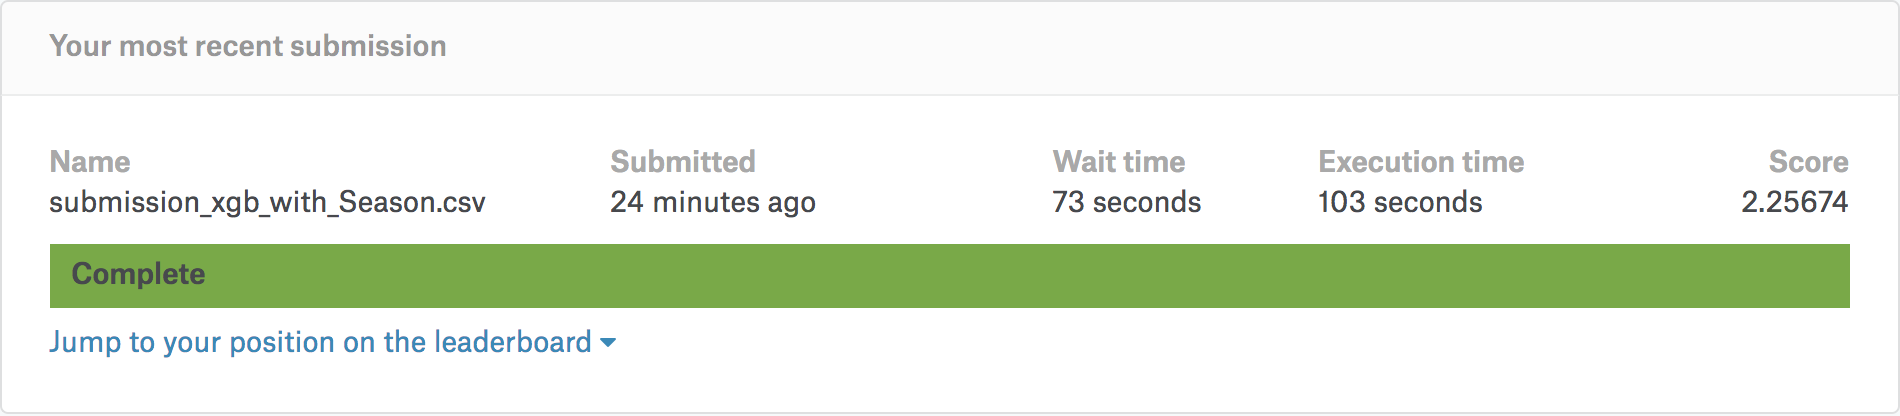

In [137]:
from IPython.display import Image
Image(filename='images/best_kaggle_submission.png') 

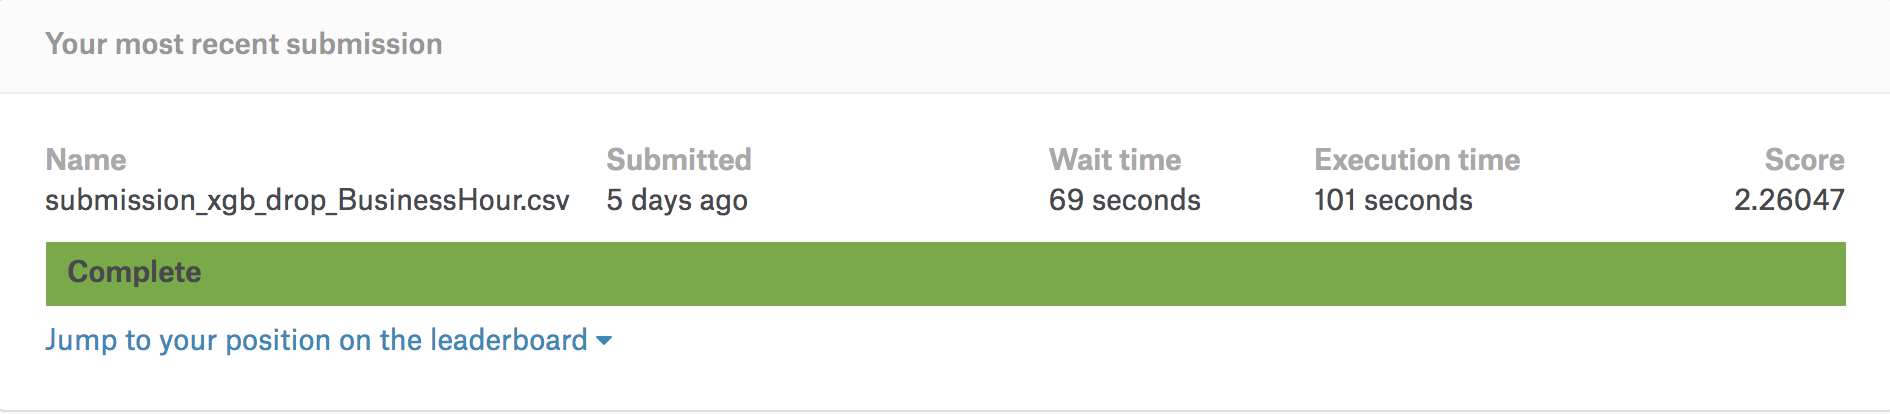

In [138]:
Image(filename='images/2nd_best_kaggle_submission.png') 

# Conclusion

This project has taught me a lot about data science and has given me hands-on experience with working with data and completing an end-to-end data science project. I've had a lot of fun visualizing, analyzing, and experimenting with the data to gain more insight. This is just the beginning of my journey into data science, and I am very excited to see what the future holds in terms of new and interesting data science problems and datasets.

- **What I learned**:
    - There are more efficient ways to label or integer encode features
        - Will use sklearn's LabelEncoder, OneHotEncoder, & MultiLabelBinarizer next time
    - Instead of just blindly training models, research more about ways to optimize the hyperparameters efficiently
        - Spent too many AWS EC2 hours with `GridSearchCV`, when I should have used *Bayesian Optimization* for efficient hyperparameter tuning
        - Do more research on the domain of the problem, certain core ML algorithms, and data processing techniques
- **What's next?**
    - AutoML with `tpot` or `auto-sklearn`
        - automate the hyperparameter tuning and model selection with AutoML packages
    - Problem Redirection (Classification ---> Regression)
        - Instead of predicting category of crime, predict X & Y coordinates (longitude & latitude) continuous values given same spatial and temporal features as well as category of crime
        - **Use case:** Dynamically concentrate police on certain serious categories of crime to prevent crimes from happening beforehand
    - Rewrite all code in the jupyter notebook to .py files
        - Modularize each of the steps with functions and/or classes
        - Useful because I can run the .py file on AWS EC2 without having to host it on jupyter notebook locally
            - Meaning I can peacefully shut down my laptop and let script run in the cloud overnight
